In [ ]:
# Models to try based on the results
# 1. Random Forest Classifier
# 2. LightGBM Classifier
# 3. XGBoost Classifier
# 4. LinearDiscriminantAnalysis
# 5. KNN?

import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, make_scorer, precision_score, recall_score, f1_score

# Models
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:


def train_evaluate_classifiers(X_train, y_train, X_test, y_test, random_state=42):
    """
    Train and evaluate multiple classifiers using 5-fold cross validation
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training labels
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series
        Test labels
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing results for each classifier
    """
    
    # Define classifiers
    classifiers = {
        "Random Forest": {
            "model": RandomForestClassifier(random_state=random_state),
            "params": {
                'n_estimators': np.arange(100, 1000, 100),
                'max_depth': np.arange(3, 11, dtype=int),
                'min_samples_split': np.linspace(0.1, 1.0, 10),
                'min_samples_leaf': np.linspace(0.1, 0.5, 5),
                'max_features': ['sqrt', 'log2'],
                'bootstrap': [True, False],
            }
        },
        "GradientBoosting": {
            "model": GradientBoostingClassifier(random_state=random_state),
            "params": {
                'n_estimators': np.arange(100, 1000, 100),
                'learning_rate': np.linspace(0.01, 0.3, 10),
                'max_depth': np.arange(3, 11, dtype=int),
                'min_samples_split': np.linspace(0.1, 1.0, 10),
                'min_samples_leaf': np.linspace(0.1, 0.5, 5),
                'max_features': ['sqrt', 'log2'],
            }
        },
        "XGBoost": {
            "model": XGBClassifier(
                random_state=random_state, 
                eval_metric='mlogloss',

            ),
            "params": {
                'max_depth': np.linspace(3, 11, dtype=int),
                'learning_rate': np.linspace(0.1, 0.3, 10),
                'n_estimators': np.arange(100, 1000, 100),
                'gamma': np.linspace(0, 5, 6),
            }
        },
        "$k$NN": {
            "model": KNeighborsClassifier(),
            "params": {
                'n_neighbors': np.arange(1, 31),
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'leaf_size': np.arange(10, 100, 10),
                "p": [1, 2]
            }
        },
        "LGBM": {
            "model": LGBMClassifier(random_state=random_state, verbosity=-1, verbose=-1),
            "params": {
                'num_leaves': np.arange(20, 130, 10),
                'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
                'min_data_in_leaf': [5, 10, 20],
                'lambda_l1': [0, 1, 1.5],
                'lambda_l2': [0, 1],
                'data_sample_strategy': ["bagging", "goss"],
                }
        },
    }
    
    # Define custom scoring functions with zero_division=0
    def precision_scorer(y_true, y_pred):
        return precision_score(y_true, y_pred, average='macro', zero_division=0)

    def recall_scorer(y_true, y_pred):
        return recall_score(y_true, y_pred, average='macro', zero_division=0)

    def f1_scorer(y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Create scorers
    scoring = {
        'accuracy': 'accuracy',
        'precision_macro': make_scorer(precision_scorer),
        'recall_macro': make_scorer(recall_scorer),
        'f1_macro': make_scorer(f1_scorer)
    }

    results = {}
    
    for name, clf_dict in classifiers.items():
        print(f"Training {name} classifier...")
        # Start timing
        start_time = time()
        
        # Get the model from the dictionary
        clf = clf_dict['model']
        
        # For small datasets or datasets with tiny classes
        if X_train.shape[0] < 500:
            cv = LeaveOneOut()  # Use LOO for very small datasets
        else:
            # Count samples in smallest class
            class_counts = y_train.value_counts()
            min_class_samples = class_counts.min()
            

            n_splits = min(5, min_class_samples)  # Use at most 5 splits, but no more than samples in smallest class
            print(f"Using {n_splits} splits due to small class size ({min_class_samples} samples in smallest class)")
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

            # # Choose appropriate number of splits based on smallest class
            # if min_class_samples < 10:
            #     n_splits = min(5, min_class_samples)  # Use at most 5 splits, but no more than samples in smallest class
            #     print(f"Using {n_splits} splits due to small class size ({min_class_samples} samples in smallest class)")
            #     cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            # else:
            #     cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
        
        # Perform cross-validation with random search
        cv_results = RandomizedSearchCV(clf, 
                                        clf_dict['params'], 
                                        cv=cv, 
                                        scoring=scoring, 
                                        refit='f1_macro', 
                                        n_iter=5,
                                        n_jobs=-1,
                                        random_state=random_state, 
                                        verbose=4)
        cv_results.fit(X_train, y_train.values.ravel())
        
        # Fit on full training data and evaluate on test set
        best_clf = cv_results.best_estimator_
        test_pred_encoded = best_clf.predict(X_test)

        test_scores = precision_recall_fscore_support(y_test.values, test_pred_encoded, average='macro', zero_division=0)
        test_accuracy = accuracy_score(y_test.values.ravel(), test_pred_encoded)
        
        # Store results
        results[name] = {
            'cv_accuracy': cv_results.cv_results_['mean_test_accuracy'].mean(),
            'cv_accuracy_std': cv_results.cv_results_['std_test_accuracy'].mean(),
            'cv_precision': cv_results.cv_results_['mean_test_precision_macro'].mean(),
            'cv_recall': cv_results.cv_results_['mean_test_recall_macro'].mean(),
            'cv_f1': cv_results.cv_results_['mean_test_f1_macro'].mean(),
            'test_accuracy': test_accuracy,
            'test_precision': test_scores[0],
            'test_recall': test_scores[1],
            'test_f1': test_scores[2],
            'training_time': time() - start_time,
            'fitted_model': best_clf,
            'best_params': cv_results.best_params_
        }
        
        print(f"DONE: {results[name]}")
    
    return results

RESULTS = {}

# Train and test the model for all datasets
approaches = {'Initial': ['real_data', 'synth_data'], 'Extra': ['real_data', 'real_pseudoreal_data', 'real_pseudoreal_synth_data']}

for approach, datasets in approaches.items():
    for dataset in datasets:
        # Load the preprocessed data
        X_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/X_train.csv")
        y_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/y_train.csv")
        X_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/X_test.csv")
        y_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/y_test.csv")
        

        print(f"\nEvaluating on {approach}_{dataset} dataset:")

        # Train and evaluate
        results = train_evaluate_classifiers(X_train, y_train, X_test, y_test)
        
        # Store results
        RESULTS[f"{approach}_{dataset}"] = results

        # Print results
        for clf_name, metrics in results.items():
            print(f"\n{clf_name}:")
            print(f"CV Accuracy: {metrics['cv_accuracy']:.3f} (±{metrics['cv_accuracy_std']:.3f})")
            print(f"Test Accuracy: {metrics['test_accuracy']:.3f}")
            print(f"Test F1-Score: {metrics['test_f1']:.3f}")
            print(f"Training Time: {metrics['training_time']:.2f} seconds")

        results_df = pd.DataFrame.from_dict(results, orient='index')
        print(results_df)

# Save results to global variable
import pickle
with open("results.pkl", "wb") as f:
    pickle.dump(RESULTS, f)

In [ ]:
for dataset_name, dataset_results in RESULTS.items():
    print(f"Results for {dataset_name.capitalize()} Dataset:\n")
    for clf_name, metrics in dataset_results.items():
        print(f"Classifier: {clf_name}")
        print(f"  CV Accuracy: {metrics['cv_accuracy']:.3f} (±{metrics['cv_accuracy_std']:.3f})")
        print(f"  CV Precision: {metrics['cv_precision']:.3f}")
        print(f"  CV Recall: {metrics['cv_recall']:.3f}")
        print(f"  CV F1-Score: {metrics['cv_f1']:.3f}")
        print(f"  Test Accuracy: {metrics['test_accuracy']:.3f}")
        print(f"  Test F1-Score: {metrics['test_f1']:.3f}")
        print(f"  Training Time: {metrics['training_time']:.2f} seconds")
        print(f"  Best Parameters: {metrics['best_params']}")
        print()

In [ ]:
markdown_text = "# Baseline Classifier Evaluation Results\n\n"
markdown_text += """
> The following table shows the results of the baseline classifiers on the real and synthetic datasets.
> The results are based on 5-fold cross-validation with default parameters.
> The results are displayed in descending order of F1-Score.

"""

# make a markdown table from the results
for dataset_name, results in RESULTS.items():
    markdown_text += f"## {dataset_name.capitalize()} Dataset\n\n"
    
    # Create table header
    markdown_text += "| Classifier | CV Accuracy | Test Accuracy | Test F1-Score | Training Time (s) | Efficiency (F1/s) |\n"
    markdown_text += "|------------|-------------|---------------|---------------|------------------| ------------------ |\n"
    
    # Order by f1-score
    results_ord = {k: v for k, v in sorted(results.items(), key=lambda item: item[1]['test_f1'], reverse=True)}

    # Add each classifier's results as a row
    for clf_name, metrics in results_ord.items():
        training_time_to_f1_ratio = metrics['test_f1'] / metrics['training_time']
        markdown_text += f"| {clf_name} | {metrics['cv_accuracy']:.3f} (±{metrics['cv_accuracy_std']:.3f}) | "
        markdown_text += f"{metrics['test_accuracy']:.3f} | {metrics['test_f1']:.3f} | {metrics['training_time']:.2f} | {training_time_to_f1_ratio:.2f} |\n"
    markdown_text += "\n"  # Add space between dataset tables

# Write to file
with open('classification_results.md', 'w') as f:
    f.write(markdown_text)

print("Results have been written to classification_results.md")
print(RESULTS.keys())
print(RESULTS['Extra_real_pseudoreal_data'].keys())

Top 5 models selected for ensemble:
1. Initial_real_data - LGBM: F1=0.823
2. Initial_synth_data - XGBoost: F1=0.819
3. Initial_synth_data - LGBM: F1=0.815
4. Initial_real_data - XGBoost: F1=0.810
5. Initial_real_data - $k$NN: F1=0.738
Using soft voting method


c:\Users\danii\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danii\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danii\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danii\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



VotingClassifier Performance:
  Accuracy: 0.542
  F1-Score: 0.141
  Precision: 0.230
  Recall: 0.153

StackingClassifier Performance:
  Accuracy: 0.500
  F1-Score: 0.117
  Precision: 0.128
  Recall: 0.135

VotingClassifier Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.14      0.25         7
      Normal_Weight       0.61      0.93      0.73        55
 Overweight_Level_I       0.00      0.00      0.00         9
Overweight_Level_II       0.00      0.00      0.00         2
     Obesity_Type_I       0.00      0.00      0.00         1
    Obesity_Type_II       0.00      0.00      0.00        11
   Obesity_Type_III       0.00      0.00      0.00        11

           accuracy                           0.54        96
          macro avg       0.23      0.15      0.14        96
       weighted avg       0.42      0.54      0.44        96


StackingClassifier Classification Report:
                     precision    re

c:\Users\danii\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danii\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danii\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danii\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

,Model,Accuracy,F1-Score,Precision,Recall,Time
0,VotingClassifier,0.541667,0.140545,0.229592,0.152876,4.734757
1,StackingClassifier,0.500000,0.117017,0.127551,0.135065,21.344450
2,Initial_real_data_LGBM,0.827014,0.823470,NaN,NaN,NaN
3,Initial_synth_data_XGBoost,0.822275,0.818773,NaN,NaN,NaN
4,Initial_synth_data_LGBM,0.817536,0.814963,NaN,NaN,NaN
5,Initial_real_data_XGBoost,0.815166,0.809523,NaN,NaN,NaN
6,Initial_real_data_$k$NN,0.755924,0.738224,NaN,NaN,NaN



Best ensemble classifier (voting_ensemble) saved to 'voting_ensemble_classifier.pkl'


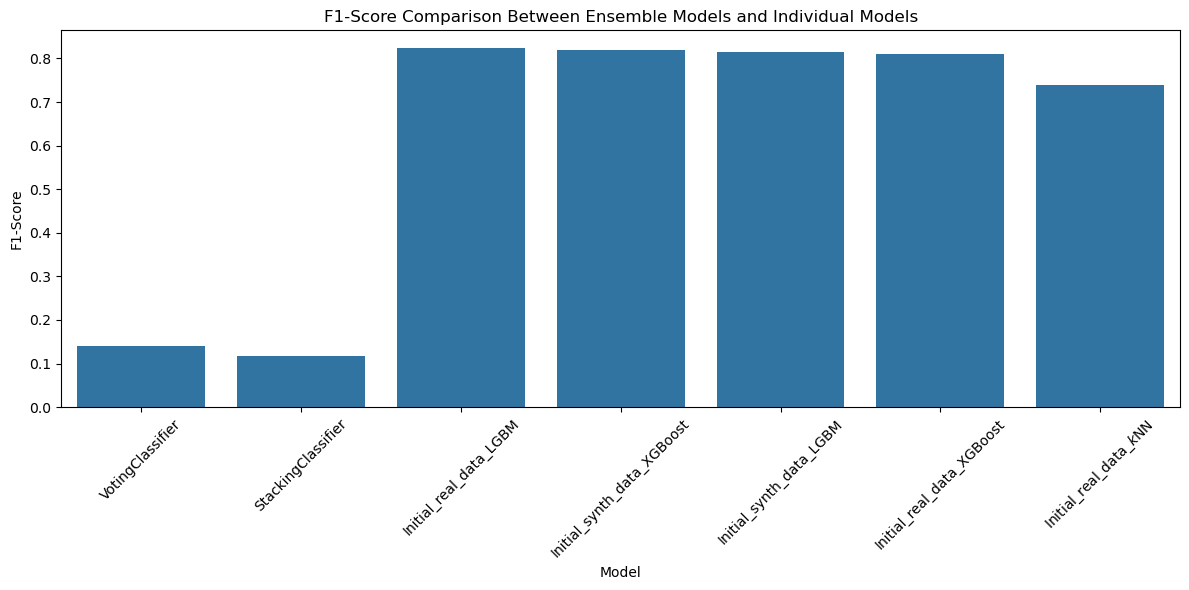

In [26]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from time import time
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# No need to reload RESULTS as it's already loaded in the notebook
with open("results.pkl", "rb") as f:
    RESULTS = pickle.load(f)

# Collect all models and their metrics across all datasets
all_models = []
for dataset_name, dataset_results in RESULTS.items():
    for clf_name, metrics in dataset_results.items():
        all_models.append({
            'dataset': dataset_name,
            'classifier': clf_name,
            'model': metrics['fitted_model'],
            'test_f1': metrics['test_f1'],
            'test_accuracy': metrics['test_accuracy'],
            'training_time': metrics['training_time']
        })

# Sort models by F1-score (descending)
all_models_sorted = sorted(all_models, key=lambda x: x['test_f1'], reverse=True)

# Select top 5 models 
top_models = all_models_sorted[:5]
print("Top 5 models selected for ensemble:")
for i, model in enumerate(top_models):
    print(f"{i+1}. {model['dataset']} - {model['classifier']}: F1={model['test_f1']:.3f}")

# Create estimators for Voting Classifier
estimators = [(f"{model['dataset']}_{model['classifier']}", model['model']) for model in top_models]

# Create ensemble - try soft voting for classifiers that support predict_proba
try:
    # Check which models support predict_proba
    support_proba = []
    for name, model in estimators:
        try:
            if hasattr(model, 'predict_proba'):
                support_proba.append(True)
            else:
                support_proba.append(False)
        except:
            support_proba.append(False)
    
    # Use soft voting if all models support it, otherwise hard
    voting_method = 'soft' if all(support_proba) else 'hard'
    print(f"Using {voting_method} voting method")
    
    # Create weighted ensemble
    weights = [model['test_f1'] for model in top_models]
    ensemble = VotingClassifier(estimators=estimators, voting=voting_method, weights=weights)
except:
    print("Falling back to hard voting without weights")
    ensemble = VotingClassifier(estimators=estimators, voting='hard')

# Prepare also a Stacking Classifier
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=RESULTS['Extra_real_pseudoreal_data']['$k$NN']['fitted_model'],
    cv=5
)

# Get test data from the real dataset
#X_test = DATASETS["real"]["X"]["test"]
#y_test = DATASETS["real"]["y"]["test"]
#X_train = DATASETS["real"]["X"]["train"]
#y_train = DATASETS["real"]["y"]["train"]
import pandas as pd

X_train = pd.read_csv('datasets/preprocessed/Extra/real_data/X_train.csv')
y_train = pd.read_csv('datasets/preprocessed/Extra/real_data/y_train.csv').squeeze()
X_test = pd.read_csv('datasets/preprocessed/Extra/real_data/X_test.csv')
y_test = pd.read_csv('datasets/preprocessed/Extra/real_data/y_test.csv').squeeze()

# Fit and evaluate VotingClassifier
start_time = time()
ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)
ensemble_time = time() - start_time

# Fit and evaluate StackingClassifier
start_time = time()
stacking.fit(X_train, y_train)
stacking_pred = stacking.predict(X_test)
stacking_time = time() - start_time

# Calculate metrics
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_precision, ensemble_recall, ensemble_f1, _ = precision_recall_fscore_support(
    y_test, ensemble_pred, average='macro'
)

stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_precision, stacking_recall, stacking_f1, _ = precision_recall_fscore_support(
    y_test, stacking_pred, average='macro'
)

print("\nVotingClassifier Performance:")
print(f"  Accuracy: {ensemble_accuracy:.3f}")
print(f"  F1-Score: {ensemble_f1:.3f}")
print(f"  Precision: {ensemble_precision:.3f}")
print(f"  Recall: {ensemble_recall:.3f}")

print("\nStackingClassifier Performance:")
print(f"  Accuracy: {stacking_accuracy:.3f}")
print(f"  F1-Score: {stacking_f1:.3f}")
print(f"  Precision: {stacking_precision:.3f}")
print(f"  Recall: {stacking_recall:.3f}")

# Display detailed classification reports
class_names = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
               'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

print("\nVotingClassifier Classification Report:")
print(classification_report(y_test, ensemble_pred, target_names=class_names))

print("\nStackingClassifier Classification Report:")
print(classification_report(y_test, stacking_pred, target_names=class_names))

# Compare performance with individual models
results_comparison = pd.DataFrame([
    {'Model': 'VotingClassifier', 'Accuracy': ensemble_accuracy, 'F1-Score': ensemble_f1, 
     'Precision': ensemble_precision, 'Recall': ensemble_recall, 'Time': ensemble_time},
    {'Model': 'StackingClassifier', 'Accuracy': stacking_accuracy, 'F1-Score': stacking_f1, 
     'Precision': stacking_precision, 'Recall': stacking_recall, 'Time': stacking_time}
])

# Use concat instead of append (which is deprecated)
for model in top_models:
    model_df = pd.DataFrame({
        'Model': [f"{model['dataset']}_{model['classifier']}"],
        'Accuracy': [model['test_accuracy']],
        'F1-Score': [model['test_f1']],
        'Precision': [None],  # We don't have this data readily available
        'Recall': [None]      # We don't have this data readily available
    })
    results_comparison = pd.concat([results_comparison, model_df], ignore_index=True)

print("\nModel Comparison:")
display(results_comparison)

# Save the best ensemble model
best_ensemble = ensemble if ensemble_f1 > stacking_f1 else stacking
best_name = "voting_ensemble" if ensemble_f1 > stacking_f1 else "stacking_ensemble"
with open(f'{best_name}_classifier.pkl', 'wb') as f:
    pickle.dump(best_ensemble, f)
print(f"\nBest ensemble classifier ({best_name}) saved to '{best_name}_classifier.pkl'")

# Plot performance comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score', data=results_comparison)
plt.title('F1-Score Comparison Between Ensemble Models and Individual Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
!pip install shap

  Using cached shap-0.47.2-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.47.2-cp312-cp312-win_amd64.whl (545 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)


<Figure size 1200x800 with 0 Axes>

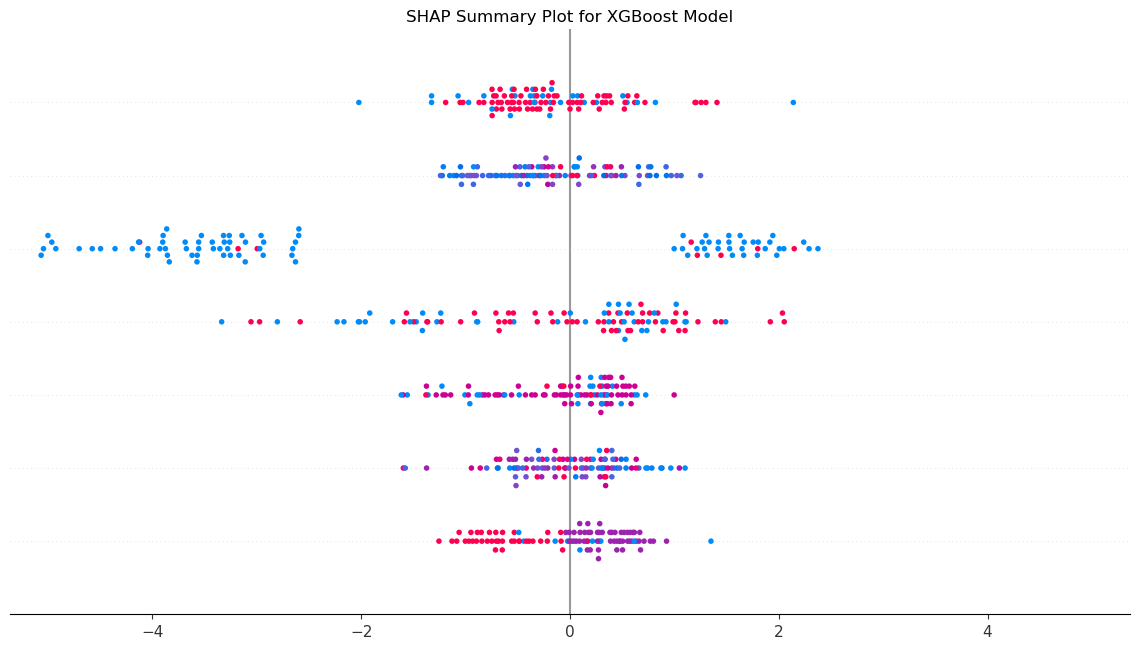

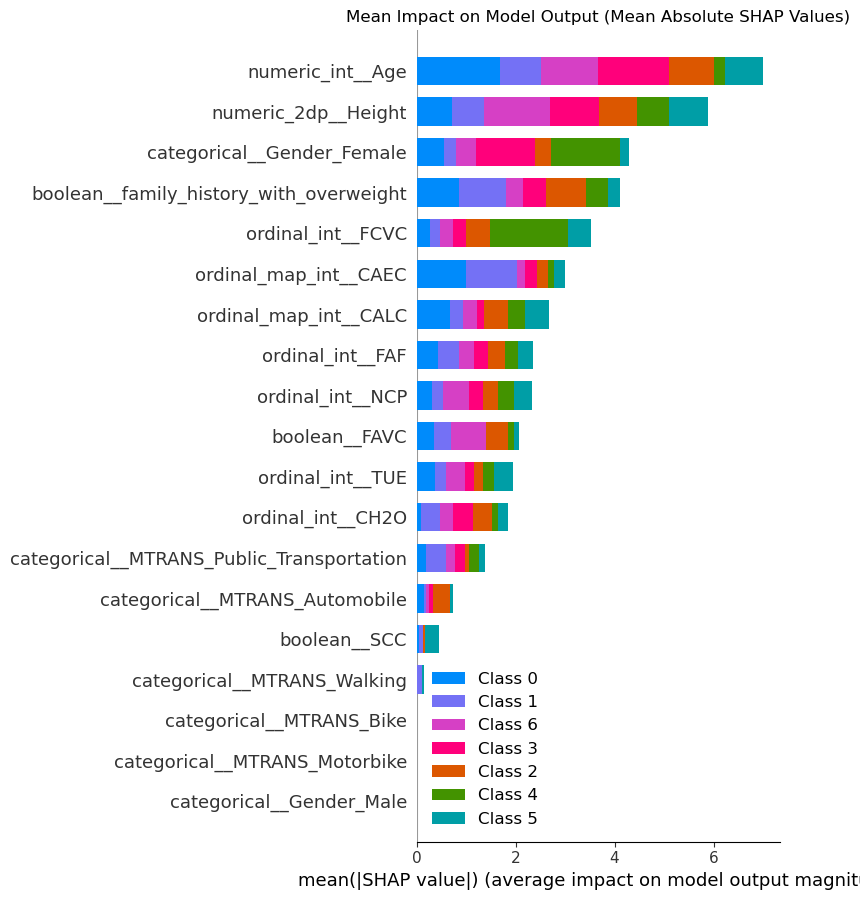

In [34]:
import shap
import matplotlib.pyplot as plt

# Get the XGBoost model and sample data

xgb_model = RESULTS['Initial_real_data']['XGBoost']['fitted_model']

# Create a SHAP explainer for the model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for a subset of training data (100 samples for visualization)
shap_values = explainer.shap_values(X_train[:100])

# Create summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train[:100], feature_names=X_train.columns, show=False)
plt.title('SHAP Summary Plot for XGBoost Model')
plt.tight_layout()
plt.show()

# Bar plot of mean absolute SHAP values
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_train[:100], feature_names=X_train.columns, plot_type="bar", show=False)
plt.title('Mean Impact on Model Output (Mean Absolute SHAP Values)')
plt.tight_layout()
plt.show()

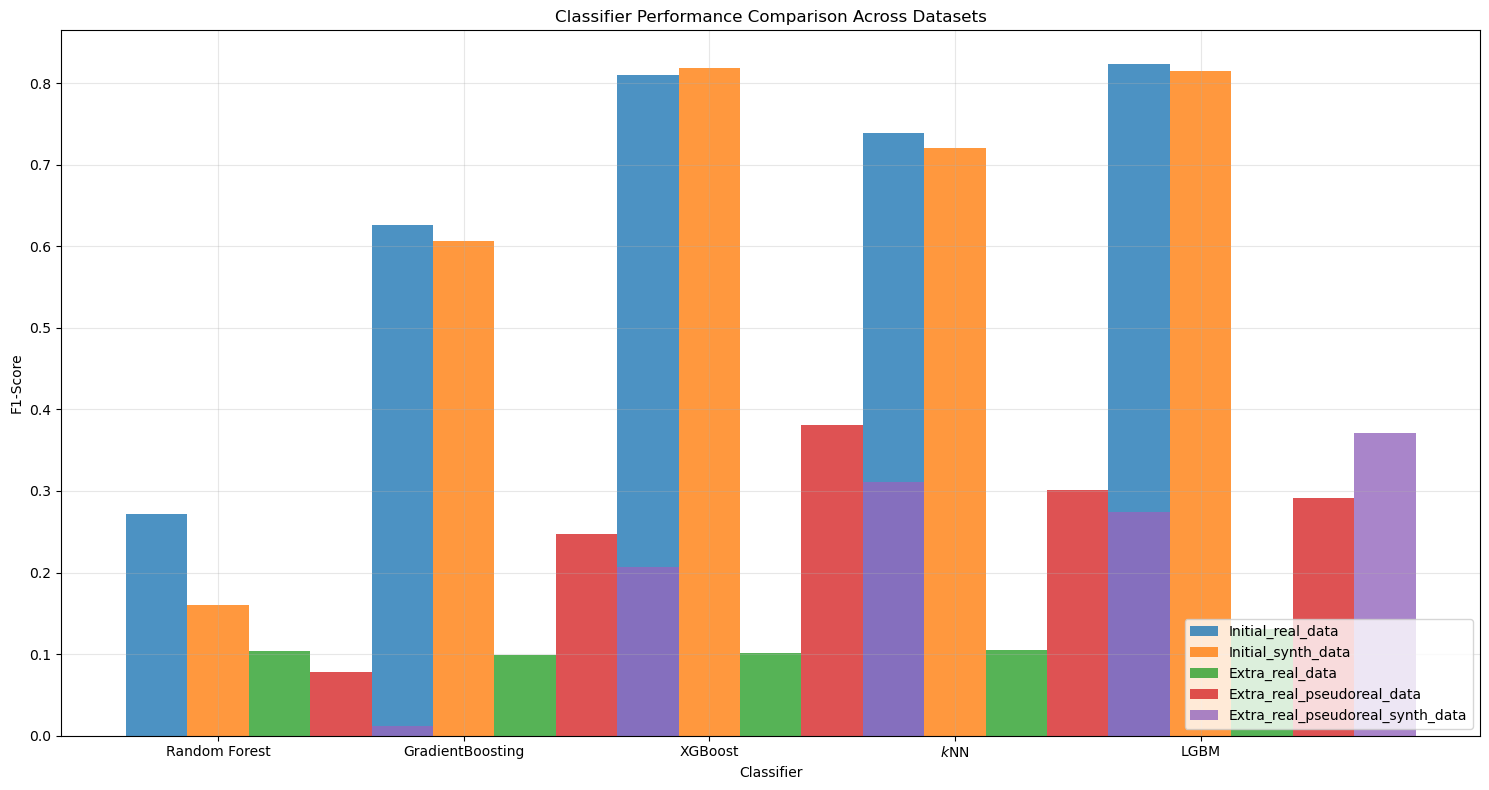

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe from the results
data = []
for dataset_name, results in RESULTS.items():
    for clf_name, metrics in results.items():
        data.append({
            'Dataset': dataset_name.capitalize(),
            'Classifier': clf_name,
            'CV Accuracy': metrics['cv_accuracy'],
            'Test Accuracy': metrics['test_accuracy'],
            'Test F1-Score': metrics['test_f1']
        })

df_metrics = pd.DataFrame(data)

# Create a grouped bar plot
plt.figure(figsize=(15, 8))
metrics = ['CV Accuracy', 'Test Accuracy', 'Test F1-Score']
x = np.arange(len(df_metrics['Classifier'].unique()))
width = 0.25

for i, dataset in enumerate(df_metrics['Dataset'].unique()):
    dataset_data = df_metrics[df_metrics['Dataset'] == dataset]
    plt.bar(x + i*width, dataset_data['Test F1-Score'], 
            width, label=f'{dataset}', alpha=0.8)

plt.xlabel('Classifier')
plt.ylabel('F1-Score')
plt.title('Classifier Performance Comparison Across Datasets')
plt.xticks(x + width, df_metrics['Classifier'].unique(), ha='center')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

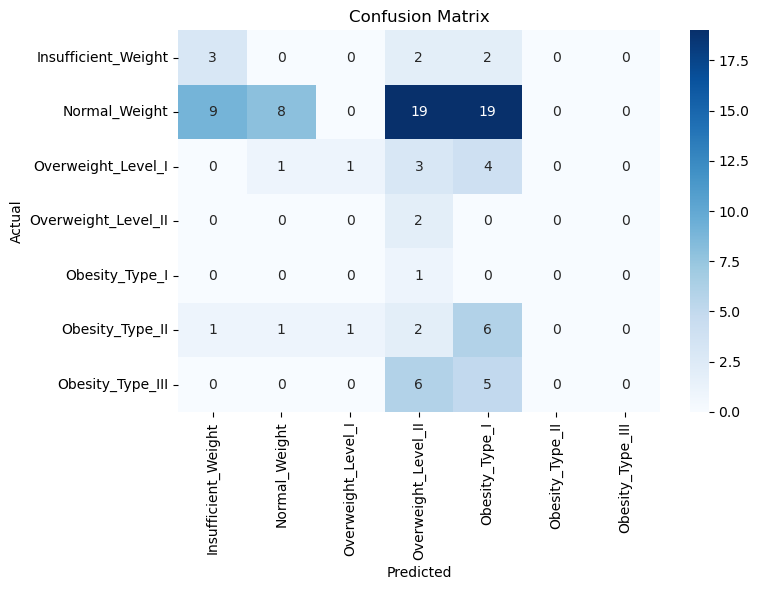

c:\Users\danii\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danii\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danii\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Insufficient_Weight,0.230769,0.428571,0.300000,7.000000
Normal_Weight,0.800000,0.145455,0.246154,55.000000
Overweight_Level_I,0.500000,0.111111,0.181818,9.000000
Overweight_Level_II,0.057143,1.000000,0.108108,2.000000
Obesity_Type_I,0.000000,0.000000,0.000000,1.000000
Obesity_Type_II,0.000000,0.000000,0.000000,11.000000
Obesity_Type_III,0.000000,0.000000,0.000000,11.000000
accuracy,0.145833,0.145833,0.145833,0.145833
macro avg,0.226845,0.240734,0.119440,96.000000
weighted avg,0.523226,0.145833,0.182198,96.000000


In [44]:
# Evaluate the RandomForest model on real+synthetic dataset
# Shows confusion matrix 
# Showsand per-class F1/precision/recall (imbalanced)

def evaluate_model_with_report(model, X_test, y_test, class_names):
    from sklearn.metrics import confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    return pd.DataFrame(report).transpose()

# Use the correct key and load test data from CSVs
model = RESULTS["Initial_real_data"]["Random Forest"]["fitted_model"]
X_test = pd.read_csv('datasets/preprocessed/Extra/real_data/X_test.csv')
y_test = pd.read_csv('datasets/preprocessed/Extra/real_data/y_test.csv').squeeze()

class_names = [
    'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
    'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'
]

report_df = evaluate_model_with_report(model, X_test, y_test, class_names)
display(report_df)


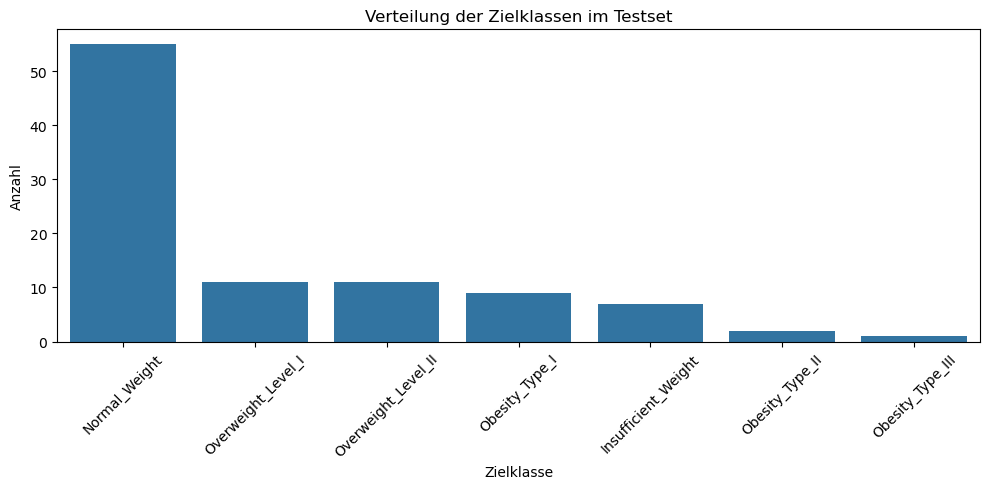

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the test labels
y_test = pd.read_csv('datasets/preprocessed/Extra/real_data/y_test.csv').squeeze()

# LabelEncoder initialisieren und fitten
label_encoder = LabelEncoder()
label_encoder.fit([
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
])

# Zielklassen im Testset dekodieren
y_test_named = pd.Series(label_encoder.inverse_transform(y_test), name="Klasse")

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(x=y_test_named, order=y_test_named.value_counts().index)
plt.title("Verteilung der Zielklassen im Testset")
plt.xticks(rotation=45)
plt.xlabel("Zielklasse")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()


